# Определение наиболее выгодного тарифа для оператора сотовой связи

# Описание проекта

- Заказчик проекта — коммерческий департамент оператора сотовой связи.
- Задача проекта — проанализировать поведение клиентов двух тарифных планов ("Смарт" и "Ультра") и определить, какой из тарифов лучше. Это необходимо для внесения изменений в распределение рекламного бюджета.

# Описание данных

Исследование основано на внутренних данных о 500 пользователях сотового оператора

Данные выданы в нескольких csv-файлах. 

Таблица users (информация о пользователях) включает следующие поля:
- user_id — уникальный идентификатор клиента
- first_name — имя клиента
- last_name — фамилия клиента
- age — возраст клиента (в годах)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания клиента
- tariff — название тарифного плана


Таблица calls (информация о звонках) включает следующие поля:
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор клиента, сделавшего звонок


Таблица messages (информация о сообщениях) включает следующие поля:
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор клиента, отправившего сообщение


Таблица internet (информация об интернет-сессиях) включает следующие поля:
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор клиента


Таблица tariffs (информация о тарифах) включает следующие поля:
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата (в рублях)
- minutes_included — количество минут в месяц, доступных по абонентской плате
- messages_included — количество сообщений в месяц, доступных по абонентской плате
- mb_per_month_included — объём интернет-трафика, доступного по абонентской плате (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

# Описание тарифов:

**Тариф «Смарт»**


- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг помимо тарифного пакета: 
1. минута разговора: 3 рубля (округление вверх значений минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 
2. сообщение: 3 рубля; 
3. 1 Гб интернет-трафика: 200 рублей.


**Тариф «Ультра»**


- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг помимо тарифного пакета: 
1. минута разговора: 1 рубль; 
2. сообщение: 1 рубль; 
3. 1 Гб интернет-трафика: 150 рублей.

**Примечание:**

Сотовый оператор всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

# Содержание

1. [Шаг 1. Загрузка датасета и подготовка его к анализу](#start)
    * [Вывод:](#start_total)
2. [Шаг 2. Предобработка данных](#preprocessing)
    * [Приведение данных к нужным типам](#float_to_int)
    * [Исправление ошибок в данных](#mistakes)
    * [Подсчет требуемых параметров](#users_add)
    * [Вывод](#preprocessing_total)
3. [Шаг 3. Анализ поведения клиентов оператора](#analysis)
    * [Вывод](#analisis_total)
4. [Шаг 4. Проверка гипотез](#hypotesis)
    * [Вывод](#hypotesis_total) 
5. [Шаг 5. Общий вывод](#total)

## Шаг 1. Загрузка датасета и подготовка его к анализу <a id="start"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy import stats as st
from functools import reduce

data_calls = pd.read_csv('.../4_mobile_calls.csv', sep = ',')
data_internet = pd.read_csv('.../4_mobile_internet.csv', sep = ',')
data_messages = pd.read_csv('.../4_mobile_messages.csv', sep = ',')
data_tariffs = pd.read_csv('.../4_mobile_tariffs.csv', sep = ',')
data_users = pd.read_csv('.../4_mobile_users.csv', sep = ',')

In [2]:
# <получение первых строк таблицы>
# <Используем метод to_datetime() для перевода строк в даты>
# <Добавляем в датафрейм столбец с месяцем>
# <Удаляем из датафрейма столбец с ненужной нам полной датой>

data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%dT%H:%M:%S')
data_calls['month'] = data_calls['call_date'].dt.month

# <Округляем продолжительность звонка вверх в соответствии с тарифом>
data_calls['duration'] = np.ceil(data_calls['duration'])


# < Создаем сводную таблицу, в которой считаем количество звонков по месяцам>
data_calls_count_duration = data_calls.pivot_table(index = ['user_id','month'], 
                                      values = 'duration',
                                      aggfunc = 'count').reset_index()

# < Создаем сводную таблицу, в которой суммируем продолжительность разговоров по месяцам>
data_calls_sum_duration = data_calls.pivot_table(index = ['user_id','month'], 
                                      values = 'duration',
                                      aggfunc = 'sum').reset_index()

# < Соединяем в одну сводную таблицу и переименовываем названия столбцов >
data_calls = data_calls_sum_duration.merge(data_calls_count_duration, on=['user_id','month'], how='outer')

# <Переименовывание названия столбца duration_x в duration_sum>
data_calls.rename(columns={'duration_x': 'duration_sum'}, inplace=True)

# <Переименовывание названия столбца duration_y в duration_count>
data_calls.rename(columns={'duration_y': 'duration_count'}, inplace=True)

data_calls.head(20)

,user_id,month,duration_sum,duration_count
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58
5,1000,10,350.0,57
6,1000,11,338.0,43
7,1000,12,333.0,46
8,1001,11,430.0,59
9,1001,12,414.0,63


In [3]:
# <Используем метод to_datetime() для перевода строк в даты>
# <Добавляем в датафрейм столбец с месяцем>
# <Удаляем из датафрейма столбец с ненужной нам полной датой>

data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%dT%H:%M:%S')
data_internet['month'] = data_internet['session_date'].dt.month

# < Создаем сводную таблицу, в которой суммируем количество мб по месяцам>
data_internet = data_internet.pivot_table(index = ['user_id','month'], 
                                      values = 'mb_used',
                                      aggfunc = 'sum').reset_index()

# <Округляем количество мегабайт вверх в соответствии с тарифом>
data_internet['mb_used'] = np.ceil(data_internet['mb_used'])

data_internet.head(10)

,user_id,month,mb_used
0,1000,5,2254.0
1,1000,6,23234.0
2,1000,7,14004.0
3,1000,8,14056.0
4,1000,9,14569.0
5,1000,10,14703.0
6,1000,11,14757.0
7,1000,12,9818.0
8,1001,11,18430.0
9,1001,12,14037.0


In [4]:
# <получение первых строк таблицы>
# <Используем метод to_datetime() для перевода строк в даты>
# <Добавляем в датафрейм столбец с месяцем>
# <Удаляем из датафрейма столбец с ненужной нам полной датой>

data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%dT%H:%M:%S')
data_messages['month'] = data_messages['message_date'].dt.month
del data_messages['message_date']

# < Создаем сводную таблицу, в которой суммируем количество смс по месяцам>
data_messages = data_messages.pivot_table(index = ['user_id','month'], 
                                      values = 'id',
                                      aggfunc = 'count').reset_index()

# <Переименовывание названия столбца id в messages_total>
data_messages.rename(columns={'id': 'messages_total'}, inplace=True)

data_messages.head(10)

,user_id,month,messages_total
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


In [5]:
# <Переименовываем название столбца tariff_name в tariff, чтобы использовать его как ключ>
data_tariffs.rename(columns={'tariff_name': 'tariff'}, inplace=True)

# <получение первых строк таблицы>
data_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [6]:
# <получение первых строк таблицы>
data_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [7]:
# < Соединение трех датафреймов с помощью reduce>
data_frames = [data_calls, data_messages, data_internet]
data_merged = reduce(lambda  left,right: pd.merge(left,right,on=['user_id','month'],
                                            how='outer'), data_frames)

# <Соединение оставшихся датафреймов (data_users и data_tariffs)>
data = data_merged.merge(data_users, on='user_id', how='left').merge( data_tariffs, on='tariff', how='left')
data.head()

,user_id,month,duration_sum,duration_count,messages_total,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,22.0,22.0,2254.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,43.0,60.0,23234.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,47.0,75.0,14004.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,52.0,81.0,14056.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,58.0,57.0,14569.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [8]:
# <получение информации о пропусках в таблице>
data.isnull().sum()

user_id                     0
month                       0
duration_sum               40
duration_count             40
messages_total            497
mb_used                    11
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

Из-за того, что мерджили таблицы, появились пропуски в столбцах duration_sum, duration_count, messages_total, mb_used и churn_date.

Churn_date - дата прекращения пользования тарифом, соответственно, пользователи с пропущенной Churn_date еще пользуются тарифом, эти пропуски не удаляются

Остальные пропуски (duration_sum, duration_count, messages_total, mb_used) заполняем нулями (не было звонков и смс, не использовались мбайты)

In [9]:
data['duration_sum'] = data['duration_sum'].fillna(0)
data['duration_count'] = data['duration_count'].fillna(0)
data['messages_total'] = data['messages_total'].fillna(0)
data['mb_used'] = data['mb_used'].fillna(0)

In [10]:
# <получение информации о пропусках в таблице>
data.isnull().sum()

user_id                     0
month                       0
duration_sum                0
duration_count              0
messages_total              0
mb_used                     0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [11]:
# <Использование метода describe() для столбцов таблицы>
data.describe()

,user_id,month,duration_sum,duration_count,messages_total,mb_used,age,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,1251.590230,8.317362,451.244866,63.038892,38.281269,17208.104543,46.641568,341.148102,20067.405103,1266.179216,979.060361,184.676416,2.387057,2.387057
std,144.659172,2.905413,241.909978,33.236368,36.148326,7570.974366,16.586109,438.044726,7082.491569,1152.749279,645.539596,23.054986,0.922199,0.922199
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,18.000000,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,1125.000000,6.000000,282.000000,40.000000,9.000000,12492.250000,32.000000,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
50%,1253.000000,9.000000,443.000000,62.000000,30.000000,16943.500000,46.000000,50.000000,15360.000000,500.000000,550.000000,200.000000,3.000000,3.000000
75%,1378.750000,11.000000,589.000000,82.000000,57.000000,21425.000000,62.000000,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000
max,1499.000000,12.000000,1673.000000,244.000000,224.000000,49746.000000,75.000000,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


### Вывод <a id="start_total"></a>

Прочитали 5 разных таблиц в формате csv.

Применили методы pd.to_datetime и dt.month, чтобы получить количество произведенных пользователями действий (смс, звонков, мб интернета) и округлили продолжительность звонков  в соответствии с политикой "Мегалайна" - вверх.

Соединили данные из 5 таблиц в одну с помощью метода merge и выявили пропуски в столбцах (duration_sum, duration_count, messages_total, mb_used), появившиеся из-за соединения разных таблиц. Заменили пропуски в столбцах duration_sum, duration_count, messages_total, mb_used на 0.

В итоговой таблице 3214 строк.

## Шаг 2. Предобработка данных<a id="preprocessing"></a>

### Приведение данных к нужным типам<a id="float_to_int"></a>

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   month                  3214 non-null   int64  
 2   duration_sum           3214 non-null   float64
 3   duration_count         3214 non-null   float64
 4   messages_total         3214 non-null   float64
 5   mb_used                3214 non-null   float64
 6   age                    3214 non-null   int64  
 7   churn_date             187 non-null    object 
 8   city                   3214 non-null   object 
 9   first_name             3214 non-null   object 
 10  last_name              3214 non-null   object 
 11  reg_date               3214 non-null   object 
 12  tariff                 3214 non-null   object 
 13  messages_included      3214 non-null   int64  
 14  mb_per_month_included  3214 non-null   int64  
 15  minu

С учетом того, что уже было проведено округление в большую сторону, можно воспрользоваться методом .astype('int64') (чтобы обработать эти столбцы, несмотря на пропуски в данных)

Следует заменить тип float64 на тип int в трех столбцах: duration, messages_total, mb_used 

In [13]:
# < Цикл для перевода в int64 c помощью метода astype>
list_of_columns = ['duration_sum', 'duration_count', 'messages_total', 'mb_used']
for column in list_of_columns:
    data[column] = data[column].astype('Int64')

data.info()

# <Изменили тип данных в выбранных столбцах>

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   user_id                3214 non-null   int64 
 1   month                  3214 non-null   int64 
 2   duration_sum           3214 non-null   Int64 
 3   duration_count         3214 non-null   Int64 
 4   messages_total         3214 non-null   Int64 
 5   mb_used                3214 non-null   Int64 
 6   age                    3214 non-null   int64 
 7   churn_date             187 non-null    object
 8   city                   3214 non-null   object
 9   first_name             3214 non-null   object
 10  last_name              3214 non-null   object
 11  reg_date               3214 non-null   object
 12  tariff                 3214 non-null   object
 13  messages_included      3214 non-null   int64 
 14  mb_per_month_included  3214 non-null   int64 
 15  minutes_included     

С помощью метода .astype('Int64') поменяли тип данных с float64 на Int64 у четырех столбцов с пропусками: duration_sum, duration_count, messages_total, mb_used

### Исправление ошибок в данных<a id="mistakes"></a>
Поясните, какие ошибки вы нашли и как их исправили. 

В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

In [14]:
# <получение суммарного количества дубликатов в таблице >
data.duplicated(keep = False).sum()

# <Автоматическая обработка дубликатов не выявила>

0

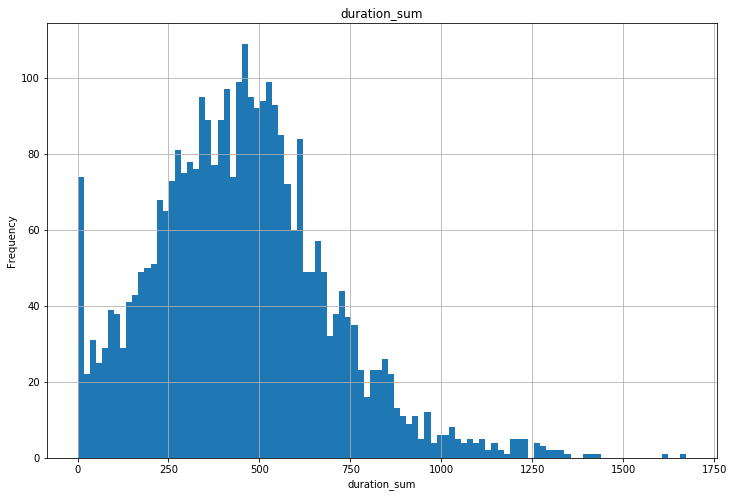

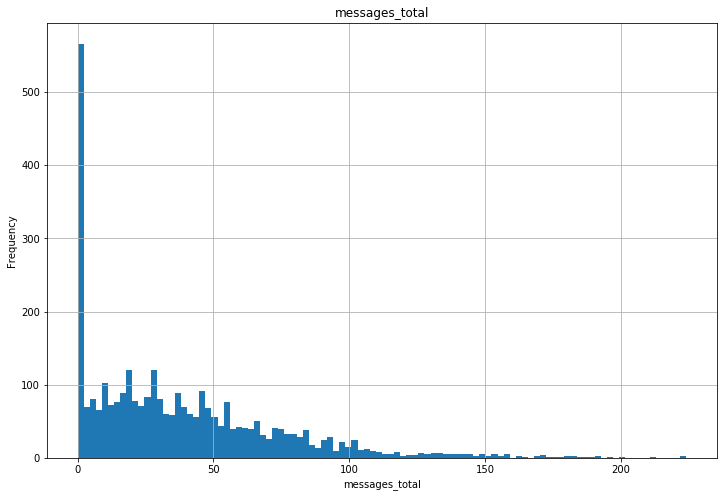

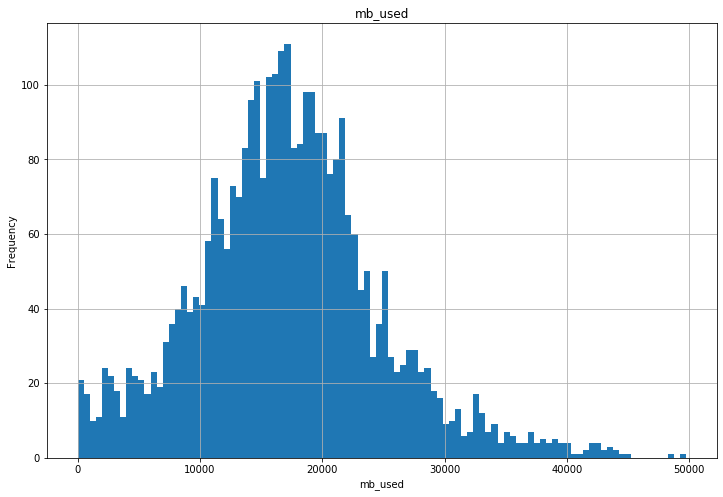

In [15]:
# <Выводим гистограммы 0-значений в столбцах: duration_sum, messages_total, mb_used >
list_of_columns = ['duration_sum', 'messages_total', 'mb_used']
for column in list_of_columns:
    plt.figure(figsize=(12, 8))
    data[column].hist(bins = 100)
    plt.title(column)
    plt.ylabel('Frequency')
    plt.xlabel(column)
    plt.show()

Считаем пользователей, которые использовали 0 минут, 0 смс и 0 мб, не пользующимися тарифом, удаляем их

In [16]:
data = data[data['duration_sum'] != 0]
data = data[data['messages_total'] != 0]
data = data[data['mb_used'] != 0]
data.head()

,user_id,month,duration_sum,duration_count,messages_total,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159,22,22,2254,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172,43,60,23234,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340,47,75,14004,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408,52,81,14056,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466,58,57,14569,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [17]:
# <Приводим к нижнему регистру столбцы city, first_name и last_name>

list_of_columns = ['city', 'first_name', 'last_name']
for column in list_of_columns:
    data[column] = data[column].str.lower()
    data[column] = data[column].replace(regex= 'ё', value='е')

In [18]:
data.describe()

,user_id,month,duration_sum,duration_count,messages_total,mb_used,age,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000
mean,1255.446992,8.346992,460.484586,64.331579,45.134211,17199.101504,46.660526,317.142857,19679.278195,1203.007519,943.684211,185.939850,2.437594,2.437594
std,146.381540,2.895752,236.789477,32.516802,34.300604,7234.364638,16.463465,427.187328,6906.944585,1124.177178,629.539220,22.483544,0.899342,0.899342
min,1000.000000,1.000000,1.000000,1.000000,1.000000,202.000000,18.000000,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,1127.000000,6.000000,297.000000,42.000000,19.000000,12565.250000,32.000000,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
50%,1266.000000,9.000000,451.000000,63.000000,38.000000,16901.500000,47.000000,50.000000,15360.000000,500.000000,550.000000,200.000000,3.000000,3.000000
75%,1385.000000,11.000000,592.250000,83.000000,63.000000,21338.000000,61.000000,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000
max,1499.000000,12.000000,1673.000000,244.000000,224.000000,49746.000000,75.000000,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


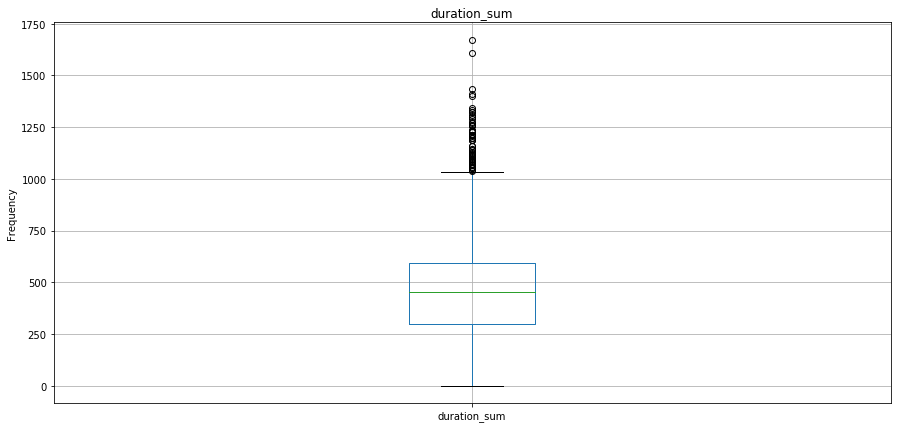

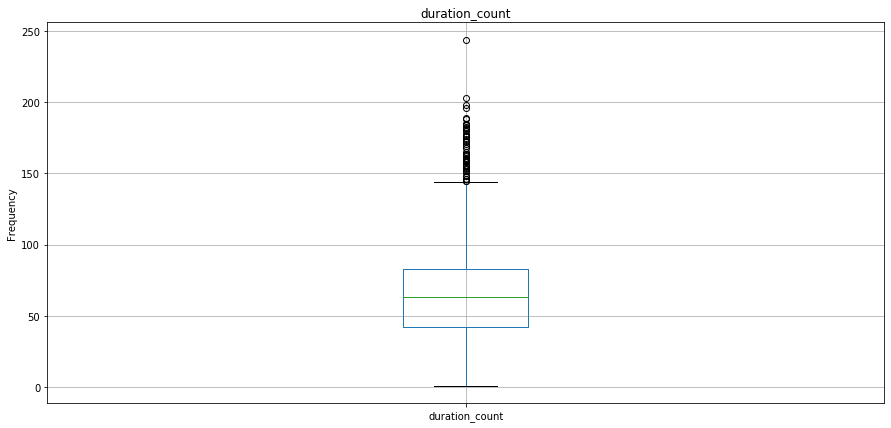

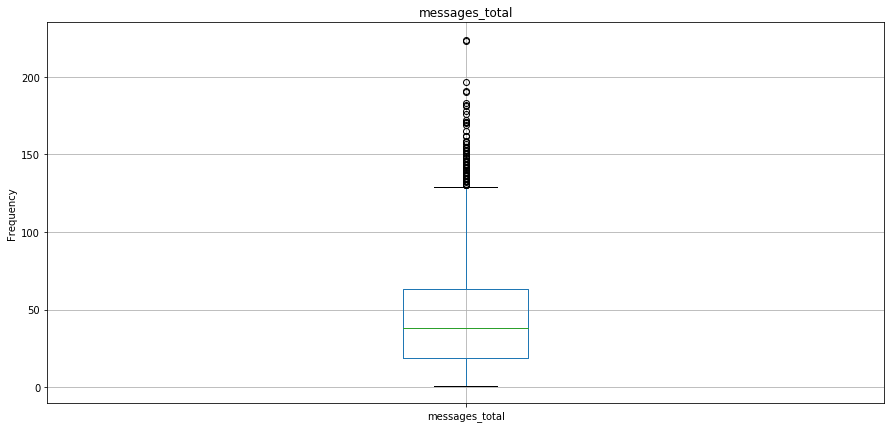

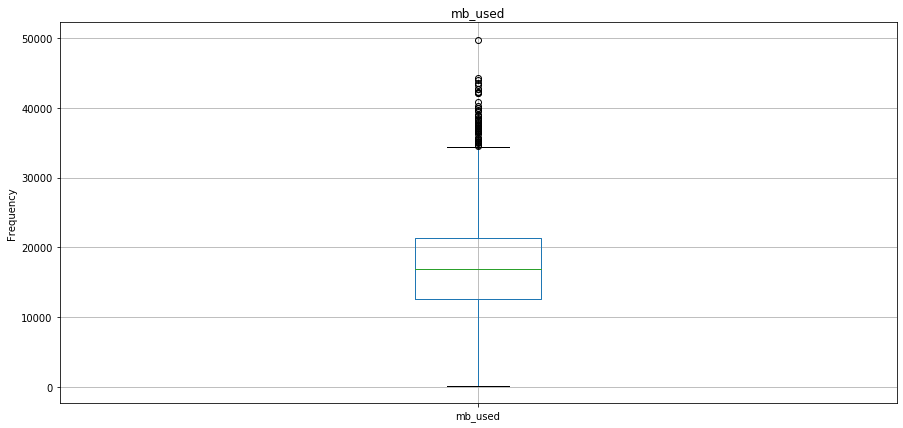

In [19]:
# <Используем boxplot для создания диаграмм размаха следующих столбцов и поиска в них выбросов>
list_of_columns = ['duration_sum', 'duration_count', 'messages_total','mb_used']
for column in list_of_columns:
    plt.figure(figsize = (15,7))
    data.boxplot(column)
    plt.title(column)
    plt.ylabel('Frequency')
    plt.show()

С учетом того, что всего строк в датафрейме 3214, необходимо удалить выбросов не больше, чем на 10% (321 выброс)

In [20]:
# <Удаляем выбросы в выбранных числовых столбцах>

#'duration_sum' - есть выбросы, приблизительно больше 1100, удаляем
# поскольку по диаграмме размаха снижается количество точек именно с 1100 минут
data = data[data['duration_sum'] <= 1100]

#'duration_count' - есть выбросы, приблизительно больше 150, удаляем
data = data[data['duration_count'] <= 150]

#'messages_total' - есть выбросы, удаляем выбросы больше 130 смс
data = data[data['messages_total'] <= 130]

#'mb_used' - есть выбросы, удаляем больше 35000 МБайт
data = data[data['mb_used'] <= 35000]

In [21]:
data.describe()

,user_id,month,duration_sum,duration_count,messages_total,mb_used,age,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2503.000000,2503.000000,2503.000000,2503.000000,2503.000000,2503.000000,2503.000000,2503.000000,2503.000000,2503.00000,2503.000000,2503.000000,2503.00000,2503.00000
mean,1255.504994,8.286456,439.474630,61.393927,41.425889,16628.909309,46.898921,279.624451,19072.664802,1104.27487,888.393927,187.914503,2.51658,2.51658
std,147.064171,2.910853,205.478584,28.097720,28.806960,6544.757361,16.294372,406.794731,6577.228494,1070.51245,599.486972,21.410249,0.85641,0.85641
min,1000.000000,1.000000,1.000000,1.000000,1.000000,202.000000,18.000000,50.000000,15360.000000,500.00000,550.000000,150.000000,1.00000,1.00000
25%,1126.000000,6.000000,291.500000,41.000000,18.000000,12413.500000,33.000000,50.000000,15360.000000,500.00000,550.000000,200.000000,3.00000,3.00000
50%,1264.000000,9.000000,443.000000,62.000000,36.000000,16663.000000,47.000000,50.000000,15360.000000,500.00000,550.000000,200.000000,3.00000,3.00000
75%,1389.000000,11.000000,570.000000,80.000000,60.000000,20821.000000,62.000000,50.000000,15360.000000,500.00000,550.000000,200.000000,3.00000,3.00000
max,1499.000000,12.000000,1074.000000,146.000000,130.000000,34889.000000,75.000000,1000.000000,30720.000000,3000.00000,1950.000000,200.000000,3.00000,3.00000


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2503 entries, 0 to 3173
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   user_id                2503 non-null   int64 
 1   month                  2503 non-null   int64 
 2   duration_sum           2503 non-null   Int64 
 3   duration_count         2503 non-null   Int64 
 4   messages_total         2503 non-null   Int64 
 5   mb_used                2503 non-null   Int64 
 6   age                    2503 non-null   int64 
 7   churn_date             134 non-null    object
 8   city                   2503 non-null   object
 9   first_name             2503 non-null   object
 10  last_name              2503 non-null   object
 11  reg_date               2503 non-null   object
 12  tariff                 2503 non-null   object
 13  messages_included      2503 non-null   int64 
 14  mb_per_month_included  2503 non-null   int64 
 15  minutes_included     

### Подсчет требуемых параметров<a id="users_add"></a>
- количество сделанных звонков и израсходованных минут разговора по месяцам;


In [23]:
# <Количество сделанных звонков и израсходованных минут разговора по месяцам было посчитано при объединении таблиц 
# и находятся в столбцах  duration_count и duration_sum>

data[['duration_count', 'duration_sum']].head(10)

,duration_count,duration_sum
0,22,159
1,43,172
2,47,340
3,52,408
4,58,466
5,57,350
6,43,338
7,46,333
10,15,117
11,26,214


- количество отправленных сообщений по месяцам;

In [24]:
# <Количество отправленных сообщений по месяцам было посчитано при объединении таблиц и находится в столбце messages_total>

data['messages_total'].head(10)

0     22
1     60
2     75
3     81
4     57
5     73
6     58
7     70
10     4
11    11
Name: messages_total, dtype: Int64

- объем израсходованного интернет-трафика по месяцам;

In [25]:
# < Объем израсходованного интернет-трафика по месяцам был посчитан при объединении таблиц и находится в столбце mb_used>

data['mb_used'].head(10)

0      2254
1     23234
2     14004
3     14056
4     14569
5     14703
6     14757
7      9818
10    10857
11    17581
Name: mb_used, dtype: Int64

In [26]:
data.head(5)

,user_id,month,duration_sum,duration_count,messages_total,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159,22,22,2254,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172,43,60,23234,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340,47,75,14004,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408,52,81,14056,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466,58,57,14569,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [27]:
# < Добавляем в таблицу столбцы, показывающие превышения над выбранным пользователем тарифом>
data['calls_over'] = data['duration_sum'] - data['minutes_included']
data['messages_over'] = data['messages_total'] - data['messages_included']
data['internet_over'] = np.ceil((data['mb_used'] - data['mb_per_month_included'])/1024)
data

,user_id,month,duration_sum,duration_count,messages_total,mb_used,age,churn_date,city,first_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_over,messages_over,internet_over
0,1000,5,159,22,22,2254,52,NaN,краснодар,рафаил,...,1000,30720,3000,1950,150,1,1,-2841,-978,-27.0
1,1000,6,172,43,60,23234,52,NaN,краснодар,рафаил,...,1000,30720,3000,1950,150,1,1,-2828,-940,-7.0
2,1000,7,340,47,75,14004,52,NaN,краснодар,рафаил,...,1000,30720,3000,1950,150,1,1,-2660,-925,-16.0
3,1000,8,408,52,81,14056,52,NaN,краснодар,рафаил,...,1000,30720,3000,1950,150,1,1,-2592,-919,-16.0
4,1000,9,466,58,57,14569,52,NaN,краснодар,рафаил,...,1000,30720,3000,1950,150,1,1,-2534,-943,-15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3169,1498,10,247,41,42,20580,68,2018-10-25,владикавказ,всеволод,...,50,15360,500,550,200,3,3,-253,-8,6.0
3170,1499,9,70,9,11,1846,35,NaN,пермь,гектор,...,50,15360,500,550,200,3,3,-430,-39,-13.0
3171,1499,10,449,68,48,17789,35,NaN,пермь,гектор,...,50,15360,500,550,200,3,3,-51,-2,3.0
3172,1499,11,612,74,59,17964,35,NaN,пермь,гектор,...,50,15360,500,550,200,3,3,112,9,3.0


In [28]:
# <Считаем помесячную выручку с каждого пользователя (вычли бесплатный лимит из суммарного количества звонков, сообщений 
# и интернет-трафика;  остаток умножили на значение из тарифного плана и прибавили абонентскую плату) >

def revenue_func(row):
    calls_over = row['calls_over']
    messages_over = row['messages_over']
    internet_over = row['internet_over']
    rub_per_minute = row['rub_per_minute']
    rub_per_message = row['rub_per_message']
    rub_per_gb = row['rub_per_gb']
    
    if calls_over > 0:
        calls = abs(calls_over*rub_per_minute)
    else:
        calls = 0
        
    if messages_over > 0:
        messages = abs(messages_over*rub_per_message)
    else: 
        messages = 0
        
    if internet_over > 0:
        internet = abs(internet_over*rub_per_gb)
    else:
        internet = 0
    return calls + messages + internet

data['revenue'] = data.apply(revenue_func,  axis = 1)
data['revenue'] = data['revenue'] + data['rub_monthly_fee']

pd.set_option('display.max_columns', None)
data.head()

,user_id,month,duration_sum,duration_count,messages_total,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_over,messages_over,internet_over,revenue
0,1000,5,159,22,22,2254,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,-2841,-978,-27.0,1950.0
1,1000,6,172,43,60,23234,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,-2828,-940,-7.0,1950.0
2,1000,7,340,47,75,14004,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,-2660,-925,-16.0,1950.0
3,1000,8,408,52,81,14056,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,-2592,-919,-16.0,1950.0
4,1000,9,466,58,57,14569,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,-2534,-943,-15.0,1950.0


#### Вывод <a id="preprocessing_total"></a>

Добавили столбцы с информацией по превышению лимита звонков (calls_over), лимита сообщений (messages_over) и лимита интернета в гб (internet_over).

Посчитали с помощью функции помесячную выручку с каждого пользователя (вычли бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножили на значение из тарифного плана и прибавили абонентскую плату, соответствующую тарифному плану)

## Шаг 3. Анализ поведения клиентов оператора <a id="analysis"></a>


- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 

In [29]:
data_ultra = data.query('tariff == "ultra"')
data_ultra

,user_id,month,duration_sum,duration_count,messages_total,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_over,messages_over,internet_over,revenue
0,1000,5,159,22,22,2254,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,-2841,-978,-27.0,1950.0
1,1000,6,172,43,60,23234,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,-2828,-940,-7.0,1950.0
2,1000,7,340,47,75,14004,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,-2660,-925,-16.0,1950.0
3,1000,8,408,52,81,14056,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,-2592,-919,-16.0,1950.0
4,1000,9,466,58,57,14569,52,NaN,краснодар,рафаил,верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,-2534,-943,-15.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,1491,11,518,71,40,17829,56,NaN,челябинск,радислав,андрейкин,2018-04-25,ultra,1000,30720,3000,1950,150,1,1,-2482,-960,-12.0,1950.0
3131,1491,12,674,90,51,22062,56,NaN,челябинск,радислав,андрейкин,2018-04-25,ultra,1000,30720,3000,1950,150,1,1,-2326,-949,-8.0,1950.0
3139,1493,11,173,26,16,11685,71,NaN,красноярск,таисия,ахматулина,2018-11-24,ultra,1000,30720,3000,1950,150,1,1,-2827,-984,-18.0,1950.0
3146,1495,8,92,17,13,2615,65,NaN,иркутск,авксентий,фокин,2018-08-28,ultra,1000,30720,3000,1950,150,1,1,-2908,-987,-27.0,1950.0


In [30]:
data_smart = data.query('tariff == "smart"')
data_smart

,user_id,month,duration_sum,duration_count,messages_total,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_over,messages_over,internet_over,revenue
10,1002,6,117,15,4,10857,59,NaN,стерлитамак,евгений,абрамович,2018-06-17,smart,50,15360,500,550,200,3,3,-383,-46,-4.0,550.0
11,1002,7,214,26,11,17581,59,NaN,стерлитамак,евгений,абрамович,2018-06-17,smart,50,15360,500,550,200,3,3,-286,-39,3.0,1150.0
12,1002,8,289,42,13,20320,59,NaN,стерлитамак,евгений,абрамович,2018-06-17,smart,50,15360,500,550,200,3,3,-211,-37,5.0,1550.0
13,1002,9,206,36,4,16692,59,NaN,стерлитамак,евгений,абрамович,2018-06-17,smart,50,15360,500,550,200,3,3,-294,-46,2.0,950.0
14,1002,10,212,33,10,13889,59,NaN,стерлитамак,евгений,абрамович,2018-06-17,smart,50,15360,500,550,200,3,3,-288,-40,-1.0,550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3169,1498,10,247,41,42,20580,68,2018-10-25,владикавказ,всеволод,акимчин,2018-07-19,smart,50,15360,500,550,200,3,3,-253,-8,6.0,1750.0
3170,1499,9,70,9,11,1846,35,NaN,пермь,гектор,корнилов,2018-09-27,smart,50,15360,500,550,200,3,3,-430,-39,-13.0,550.0
3171,1499,10,449,68,48,17789,35,NaN,пермь,гектор,корнилов,2018-09-27,smart,50,15360,500,550,200,3,3,-51,-2,3.0,1150.0
3172,1499,11,612,74,59,17964,35,NaN,пермь,гектор,корнилов,2018-09-27,smart,50,15360,500,550,200,3,3,112,9,3.0,1513.0


- Посчитайте среднее количество, дисперсию и стандартное отклонение. 

In [31]:
data_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 605 entries, 0 to 3147
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                605 non-null    int64  
 1   month                  605 non-null    int64  
 2   duration_sum           605 non-null    Int64  
 3   duration_count         605 non-null    Int64  
 4   messages_total         605 non-null    Int64  
 5   mb_used                605 non-null    Int64  
 6   age                    605 non-null    int64  
 7   churn_date             36 non-null     object 
 8   city                   605 non-null    object 
 9   first_name             605 non-null    object 
 10  last_name              605 non-null    object 
 11  reg_date               605 non-null    object 
 12  tariff                 605 non-null    object 
 13  messages_included      605 non-null    int64  
 14  mb_per_month_included  605 non-null    int64  
 15  minut

In [32]:
data.groupby('tariff').agg({'duration_sum': ['mean', 'std', 'var'], 
                            'messages_total': ['mean', 'std', 'var'],
                            'mb_used': ['mean', 'std', 'var']}).reset_index()

tariff duration_sum                           messages_total             \
                 mean         std           var           mean        std   
0  smart   418.727608  183.669115  33734.343792      38.402002  26.234700   
1  ultra   504.561983  251.696367  63351.061135      50.912397  34.014809   

                     mb_used                             
           var          mean          std           var  
0   688.259500  16166.253952  5673.197863  3.218517e+07  
1  1157.007214  18080.347107  8577.095990  7.356658e+07

- Постройте гистограммы.

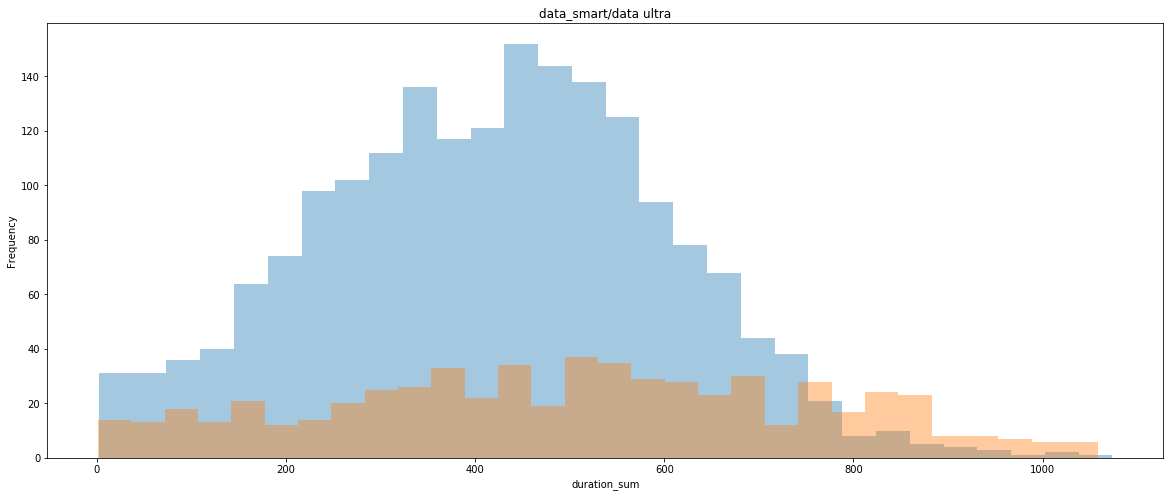

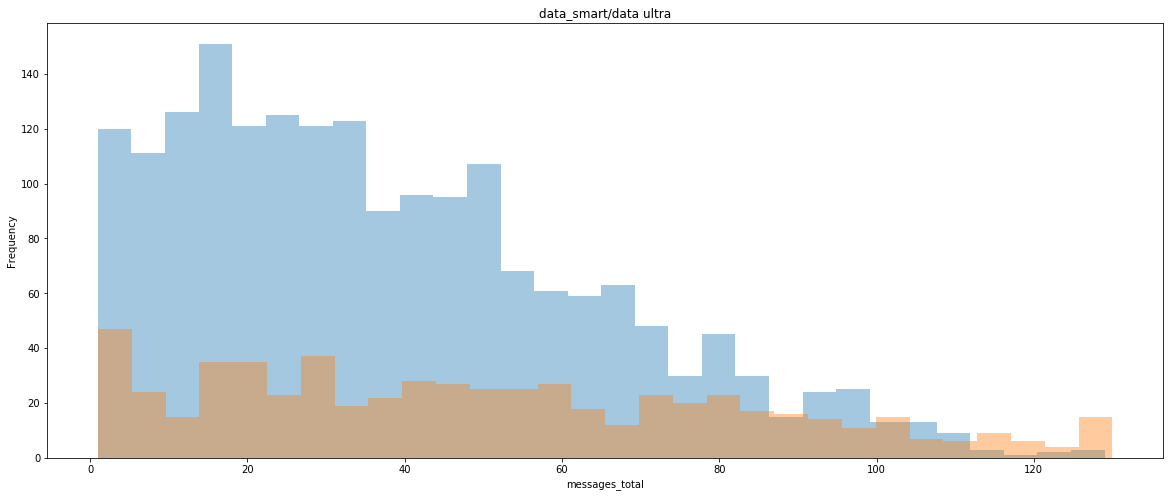

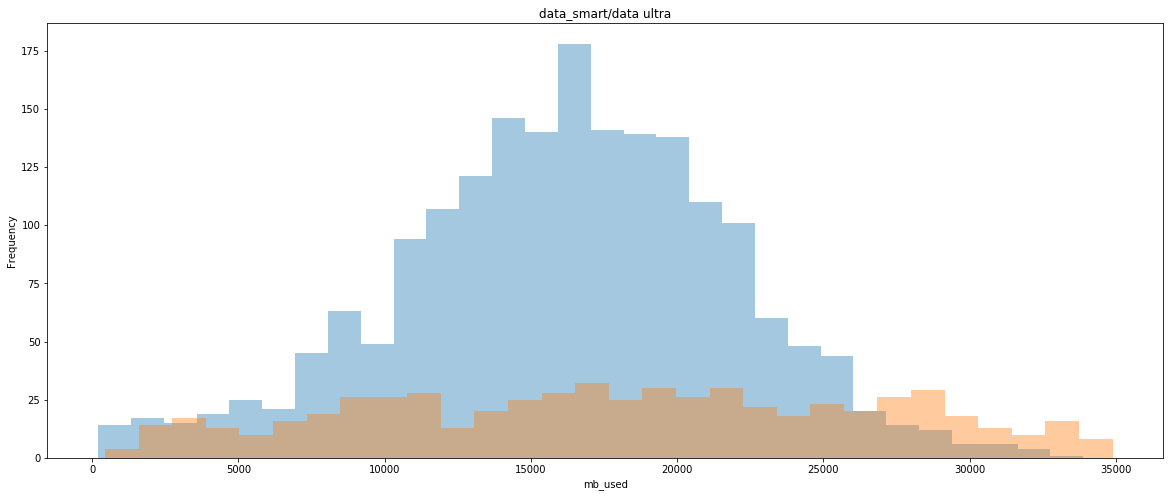

In [33]:
# <Строим диаграммы плотности для data_smart и data_ultra>
def distplot(column):
    plt.figure(figsize=(20, 8))
    plt.title('data_smart/data ultra')
    plt.ylabel('Frequency')
    sns.distplot(data_smart[column], kde = False, bins = 30)
    sns.distplot(data_ultra[column], kde = False, bins = 30)
    

distplot_columns = ['duration_sum', 'messages_total', 'mb_used'] 
for column in distplot_columns:
    distplot(column)

### Вывод <a id="analisis_total"></a>

Средние значения по столбцам duration_sum, messages_total, mb_used больше у тарифа ультра:
- Средняя продолжительность всех разговоров больше у тарифа ultra на 86 минут (505 против 419 у smart).
- Среднее количество использованного интернета также больше у тарифа ultra на 1914 мб (18080 против 16166 у smart).
- Среднее количество использованных смс все еще больше у тарифа ultra на 14 смс (51 против 38 у smart).

Стандартное отклонение (соответственно и дисперсия) также больше у всех показателей тарифа ультра, что означает больший разброс использования минут, смс и гб у пользователей тарифа ультра

На гистограмме duration_sum можно отметить, что суммарная продолжительность звонков тарифа смарт стремится к нормальному распределению, а суммарная продолжительность звонков тарифа ультра распределена широко.

На гистограмме messages_total видно, что на тарифе смарт почти нет больше 120 смс у пользователей, в то время как у тарифа ультра опять же более пологий график и есть пользователя с больше 120 смс

На гистограмме mb_used видно, что клиенты тарифа ультра используют от 0 до 35 гб, в то время как пользователи тарифа ультра - в среднем не более 33

## Шаг 4. Проверка гипотез<a id="hypotesis"></a>

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

Гипотеза H₀: "средняя выручка одной генеральной совокупности (тарифа "Ультра") равна средней выручке другой генеральной совокупности (тарифа "Смарт")".

Гипотеза H₁: "средняя выручка одной генеральной совокупности (тарифа "Ультра") не равна средней выручке другой генеральной совокупности (тарифа "Смарт")".

In [34]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(data_smart['revenue'], data_ultra['revenue'], equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 3.545549128284855e-246
Отвергаем нулевую гипотезу


- средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.


Гипотеза H₀: "средняя выручка одной генеральной совокупности (пользователи из Москвы) равна средней выручке другой генеральной совокупности (пользователи не из Москвы)".

Гипотеза H₁: "средняя выручка одной генеральной совокупности (пользователи из Москвы) не равна средней выручке другой генеральной совокупности (пользователи не из Москвы)".

In [35]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

data_moscow = data.query('city == "москва"')
data_other_cities = data.query('city != "москва"')
results = st.ttest_ind(data_moscow['revenue'], data_other_cities['revenue'], equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.33566437132162696
Не получилось отвергнуть нулевую гипотезу


- Поясните, какой критерий использовали для проверки гипотез и почему.


На всякий случай (если дисперсии выборок различаются), был использован тест Уэлча, что незначительно повысило точность.

### Вывод <a id="hypotesis_total"></a>

Проверены 2 гипотезы (4, если считать H0 и H1 у каждой) с помощью теста Уэлча.

Нулевая гипотеза, что средняя выручка одной генеральной совокупности (тарифа "Ультра") равна средней выручке другой генеральной совокупности (тарифа "Смарт"), была отвергнута.

Нулевую гипотезу, что средняя выручка одной генеральной совокупности (пользователи из Москвы) равна средней выручке другой генеральной совокупности (пользователи не из Москвы), не получилось отвергнуть.

Таким образом, можно сделать предположение, что средняя выручка генеральной совокупности зависит от того, каким тарифом пользуется пользователь, однако предположительно не зависит от города (Москвы), в котором пользователь проживает.

## Шаг 5. Общий вывод<a id="total"></a>


In [36]:
# <Информация о том, какой тариф приносит больше выручки в большем объеме>

data.pivot_table(index = 'tariff', values = ['revenue'], aggfunc = ['mean', 'std', 'var']).reset_index()

,tariff,mean,std,var
,,revenue,revenue,revenue
0,smart,1269.040569,775.866793,601969.280905
1,ultra,1973.801653,99.687062,9937.510262


In [37]:
# <Информация о том, какой тариф приносит больше дополнительной выручки>

data['revenue_dop'] = data['revenue'] - data['rub_monthly_fee']
data.pivot_table(index = 'tariff', values = ['revenue_dop'], aggfunc = ['mean', 'std', 'var']).reset_index()

,tariff,mean,std,var
,,revenue_dop,revenue_dop,revenue_dop
0,smart,719.040569,775.866793,601969.280905
1,ultra,23.801653,99.687062,9937.510262


In [38]:
data.groupby('tariff').agg({'duration_sum': ['mean', 'std', 'var'], 
                            'messages_total': ['mean', 'std', 'var'],
                            'mb_used': ['mean', 'std', 'var']}).reset_index()

tariff duration_sum                           messages_total             \
                 mean         std           var           mean        std   
0  smart   418.727608  183.669115  33734.343792      38.402002  26.234700   
1  ultra   504.561983  251.696367  63351.061135      50.912397  34.014809   

                     mb_used                             
           var          mean          std           var  
0   688.259500  16166.253952  5673.197863  3.218517e+07  
1  1157.007214  18080.347107  8577.095990  7.356658e+07

Выяснили следующие значения продолжительности звонков, количества отправленных сообщений и использованных мегабайт:

Средняя продолжительность всех разговоров пользователя за месяц:
- Тариф ultra - 505 минут
- Тариф smart - 419 минут

Среднее количество использованного пользователем интернета за месяц: 
- Тариф ultra - 18080 мб
- Тариф smart - 16166 мб

Среднее количество использованных пользователем смс за месяц:
- Тариф ultra - 51 смс
- Тариф smart - 38 смс

Выяснили, что есть неактивные пользователи, которые не используют ни минуты разговора, ни смс, ни гб интернета.

Общая месячная выручка с пользователя:
- Тариф ultra - 1974 руб.
- Тариф smart - 1269 руб.

Дополнительная месячная выручка с пользователя:
- Тариф ultra - 24 руб.
- Тариф smart - 719 руб.

Итоговый вывод: 

Можно сделать предположение, что средняя выручка генеральной совокупности зависит от того, каким тарифом пользуется пользователь, однако предположительно не зависит от города (Москвы), в котором пользователь проживает.

Даже с учетом того, что у тарифа "Смарт" в разы больше значения дополнительной месячной выручки, выгоднее для компании будет тариф "Ультра".